In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd /raid/home/myang349/recsys-filterbubbles/

/raid/home/myang349/recsys-filterbubbles


# Imports

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
from os import listdir
from os.path import isfile, join
from tracin.tracin import (
    save_tracin_checkpoint,
    load_tracin_checkpoint,
    calculate_tracin_influence,
)
import pandas as pd
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities 
from LSTM_clean.model import LSTM 
from collections import Counter
import numpy as np
import pickle
from collections import defaultdict
import copy
from torch.optim import SGD
from lstm_wrapper import train_model, get_topk_predictions, train_model2
from dataclasses import dataclass
import matplotlib.pyplot as plt
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities, shannon_index, gini_simpson_index, num_unique

In [5]:
# Data Location
# Use SAVE_PREFIX to mark different datasets
SAVE_PREFIX = "104k"
SAVE_FOLDER = "/raid/home/myang349/recsys-filterbubbles/data/twitch_sequence/"
SAVE_TRAIN_NAME = SAVE_PREFIX + "train.data"
SAVE_VALID_NAME = SAVE_PREFIX + "valid.data"
SAVE_TEST_NAME = SAVE_PREFIX + "test.data"
SAVE_COMMUNITY_NAME = SAVE_PREFIX + "lstm_idx_communities.data"

In [6]:
train_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TRAIN_NAME), allow_pickle=True)
valid_data = np.load(os.path.join(SAVE_FOLDER, SAVE_VALID_NAME), allow_pickle=True)
test_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TEST_NAME), allow_pickle=True)

# Training

In [79]:
model, train_losses, test_losses, test_mrr, test_hits = train_model()

Device is cuda
Train: 74049, Valid: 9202
Model is  LSTM(
  (item_emb): Embedding(3312, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3312, bias=True)
)

Training and testing
train # = 74049, test # = 9202

Epoch 0	Train Loss: 0.015869749091597503	Test MRR: 0.003664021222477743	Test Recall@10: 0.004672897196261682	Elapsed time: 1.4491989612579346
saving checkpoint to /raid/home/myang349/recsys-filterbubbles/checkpoints_v2/lstm_checkpoint_epoch0.pt
Epoch 5	Train Loss: 0.015591022855569115	Test MRR: 0.05214090489107543	Test Recall@10: 0.11627906976744186	Elapsed time: 7.714997291564941
Epoch 10	Train Loss: 0.014873462633934702	Test MRR: 0.0535475347059148	Test Recall@10: 0.11432297326668116	Elapsed time: 7.318025827407837
saving checkpoint to /raid/home/myang349/recsys-filterbubbles/checkpoints_v2/lstm_checkpoint_epoch10.pt
Epoch 15	Train Loss: 0.014158804615733062	Test MRR: 0.06394374788204953	Test Recall@10: 0.1363833949141491	

In [8]:
model

LSTM(
  (item_emb): Embedding(3312, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3312, bias=True)
)

In [12]:
import seaborn as sns
sns.set(style='darkgrid')

In [13]:
x = [5*i for i in range(len(train_losses))]

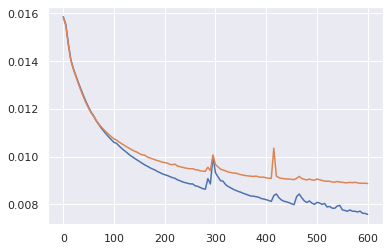

In [26]:
plt.plot(x, [x/74049 for x in train_losses])
plt.plot(x, test_losses)

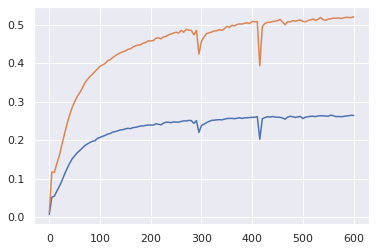

In [29]:
plt.plot(x, test_mrr)
plt.plot(x, test_hits)

In [80]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
# sequences = [list(reversed(pt[0]))[:10] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [81]:
# Generate predictions
predictions = get_topk_predictions(model, sequences, k=10)

In [82]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

# Compute diversity of predictions

In [83]:
def avg_diversity(predictions, community_dict):
    count = []
    for seq in predictions:
        c = get_communities(seq, community_dict)
        count.append(diversity_metric(c, community_dict))
    return count
                  

In [84]:
diversity_metric = num_unique
count = avg_diversity(predictions, community_dict)
print(sum(count)/len(count))
diversity_metric = gini_simpson_index
count = avg_diversity(predictions, community_dict)
sum(count)/len(count)

2.014344707672245


0.2382069115409702

In [53]:
diversity_metric = gini_simpson_index
count = avg_diversity(predictions, community_dict)
sum(count)/len(count)

0.2199413171049796

# Model v2

In [56]:
# GETS COMMUNITIES FOR YOU
def is_filter_bubble(sequence, label):
    communities = get_communities(sequence, community_dict)
    hm_communities = Counter(communities)
    for k, v in hm_communities.items():
        if v >= 0.95 * len(communities) and k == community_dict[label]:
            return 1.0
    return 0.0

# # Checks label is not the majority comm
# def is_breaking_bubble(sequence, label):
#     communities = get_communities(sequence, community_dict)
#     hm_communities = Counter(communities)
#     for k, v in hm_communities.items():
#         if v >= 0.7 * len(communities) and k != community_dict[label]:
#             return 1.0
#     return 0.0

# Checks label is a brand new community
def is_breaking_bubble(sequence, label):
    communities = get_communities(sequence, community_dict)
    hm_communities = Counter(communities)
    for k, v in hm_communities.items():
        if v >= 0.9 * len(communities) and community_dict[label] not in communities:
            return 1.0
    return 0.0

In [59]:
sequences = [pt[0] for pt in train_data]
gt = [pt[1] for pt in train_data]

In [66]:
new_data = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) > 10 and is_filter_bubble(sequence, gt[i]):
        continue
    else:
        new_data.append([sequence, gt[i]])

In [67]:
len(new_data)

59659

In [68]:
len(sequences)

74049

In [71]:
model2 = train_model2(new_data, valid_data)

Device is cuda
Train: 59659, Valid: 9202
Model is  LSTM(
  (item_emb): Embedding(3312, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3312, bias=True)
)

Training and testing
train # = 59659, test # = 9202

Epoch 0	Train Loss: 0.01590600985087104	Test MRR: 0.0034400227797218197	Test Recall@10: 0.004672897196261682	Elapsed time: 1.626948356628418
saving checkpoint to /raid/home/myang349/recsys-filterbubbles/checkpoints_v2/lstm_checkpoint_epoch0.pt
Epoch 5	Train Loss: 0.015671550341377724	Test MRR: 0.046694075306456986	Test Recall@10: 0.09258856770267333	Elapsed time: 6.191162109375
Epoch 10	Train Loss: 0.015125337321059027	Test MRR: 0.05344300524853355	Test Recall@10: 0.1163877417952619	Elapsed time: 6.24795389175415
saving checkpoint to /raid/home/myang349/recsys-filterbubbles/checkpoints_v2/lstm_checkpoint_epoch10.pt
Epoch 15	Train Loss: 0.01438516157304336	Test MRR: 0.05579174516986182	Test Recall@10: 0.11204086068246033	Elap

In [78]:
sequences = [pt[0] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

# Generate predictions
predictions = get_topk_predictions(model2[0], sequences, k=10)
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))
def avg_diversity(predictions, community_dict):
    count = []
    for seq in predictions:
        c = get_communities(seq, community_dict)
        count.append(diversity_metric(c, community_dict))
    return count

diversity_metric = num_unique
count = avg_diversity(predictions, community_dict)
print(sum(count)/len(count))
diversity_metric = gini_simpson_index
count = avg_diversity(predictions, community_dict)
sum(count)/len(count)

2.341447511410563


0.31489024125189735

# Add breaking bubble points